In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install torchtext==0.6.0

In [ ]:
!pip install fugashi[unidic-lite]

In [ ]:
!pip install -U spacy

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.3.2)


In [ ]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
!python -m spacy download ja_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('ja_core_news_sm')


# INTRODUCTION
The most common sequence-to-sequence (seq2seq) models are *encoder-decoder* models, which commonly use a *recurrent neural network* (RNN) to *encode* the source (input) sentence into a single vector. In this notebook, we'll refer to this single vector as a *context vector*. We can think of the context vector as being an abstract representation of the entire input sentence. This vector is then *decoded* by a second RNN which learns to output the target (output) sentence by generating it one word at a time.

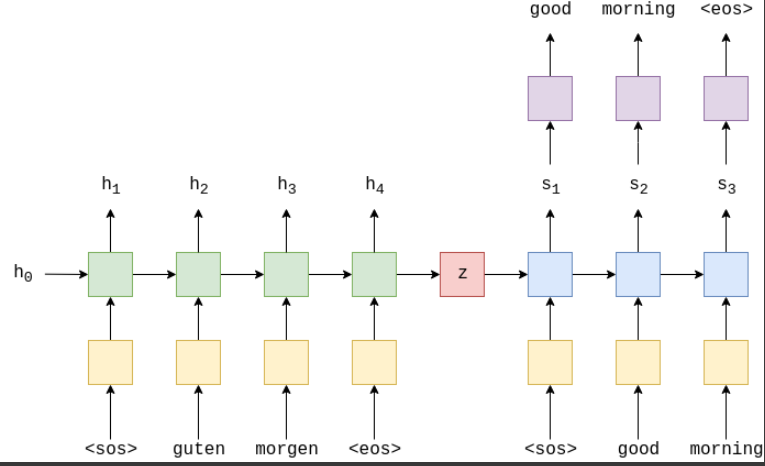

Change the path

In [1]:
import numpy as np
import pandas as pd

path = "drive/My Drive/NLP/kyoto_lexicon.csv"
df = pd.read_csv(path, error_bad_lines=False, usecols=[0,1], header=0)

FileNotFoundError: [Errno 2] File drive/My Drive/NLP/kyoto_lexicon.csv does not exist: 'drive/My Drive/NLP/kyoto_lexicon.csv'

In [ ]:
import torch
import spacy
import random
import math
import time
import numpy as np
import torch.nn as nn
import pandas as pd
import torch.optim as optim

from torchtext.data import Field, BucketIterator, TabularDataset

In [ ]:
df.head()

,日本語,英語
0,102世吉田日厚貫首,"the 102nd head priest, Nikko TOSHIDA"
1,1月15日：成人祭、新年祭,"15th January: Seijin-sai (Adult Festival), the..."
2,1月3日：家運隆盛、商売繁盛祈願祭,3rd January: Prayer Festival for the prosperit...
3,1月7日：七種粥神事,7th January: Nanakusa-gayu shinji (a divine se...
4,21世紀COEプログラム,The 21st Century Center Of Excellence Program


In [ ]:
df.columns

Index(['日本語', '英語'], dtype='object')

In [ ]:
df.rename(columns = {'日本語':'Japanese'}, inplace = True) 
df.rename(columns = {'英語':'English'}, inplace = True) 

In [ ]:
spacy_ja = spacy.load('ja_core_news_sm')
spacy_en = spacy.load('en_core_web_sm') 

In [ ]:
def tokenize_ja(text):
    return [tok.text for tok in spacy_ja.tokenizer(text)][::-1]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [ ]:
train.to_csv('train.csv', index=False)
validate.to_csv('val.csv', index=False)
test.to_csv('test.csv', index=False)

Our model takes the src as the japanese text and the target as the english text. And we are appending the and tokens to the start and end of the sentence respectively.

In [ ]:
SRC = Field(tokenize = tokenize_ja, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [ ]:
data_fields = [('Japanese', SRC), ('English', TRG)]


Splitting the dataset into train, test and validation set.

In [ ]:
train, val, test = TabularDataset.splits(path='./',
                        train='train.csv', 
                        validation='val.csv',
                        test = 'test.csv',
                        format='csv',
              
                        fields = data_fields )


In [ ]:
print(train.examples[0])

In [ ]:
len(train.examples), len(val.examples), len(test.examples)

(31190, 10397, 10398)

In [ ]:
SRC.build_vocab(train, min_freq = 2)
TRG.build_vocab(train, min_freq = 2)

In [ ]:
print(len(SRC.vocab))
print(len(TRG.vocab))

8628
9640


Then train_iter, valid_iterator, test_iter data is created using BucketIterator. We have used BucketIterator becuase it creates batched in such a way that it minimizes the amount of padding in both the source and the target sentences. The source attributes are PyTorch sensors that contains sequence of indexes of the tokens of the sources sentences and the target attribute are again the PyTorch sensors that contains sequence of indexes of the tokens of the target sentences.

torch.device is also defined. If a GPU is available torch.device puts tensors on the GPU. The torch.cuda.is_available() function will return true if a GPU is identified. This tells us if the tensors should run in a standard runtime or GPU runtime. We pass this device to the iterator.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
BATCH_SIZE = 20

train_iter = BucketIterator(
    train,
    batch_size=BATCH_SIZE,
    device = device   
)

valid_iter = BucketIterator(
    val,
    batch_size=BATCH_SIZE,
    device = device
)

test_iter = BucketIterator(
    test,
    batch_size = BATCH_SIZE,
    device = device
)

As implemented in the reference, we are building the model into three parts. Encoder Decoder seq2seq model

Encoder We have used 2 Layer LSTM encoder. The input sentence after being embedded goes into the first bottom layer of the RNN and the hidden states. The output of the states are used as inputs to the RNN for the layer above. So, only the hidden state from the first layer is passed as input to the second layer. Not all the cell state are passed.

The embeddings are created by passing the sources sentences to the forward method which are converted into the dense vectors using the embedding layer. These are then passed to RNN. The forward function returns only the hidden and cell. THe n_directions is 1.

We have inherited torch.nn.module and used the init function which takes some arguments explained in the next section.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        return hidden, cell

The decoder outputs single token per step i.e., it does a single step of decoding. As the hidden and cell state is passed from the forward function of the encoder, the first layer of the encoder receives it and feeds it to the LSTM to produce a new hidden and cell state.

In the forward method we take a batch of input tokens, previous hidden states and previous cell states. The imput token length will always be 1 as we are decoding one token at a time. Then as done in the encoder we pass it to the embedding layer and apply dropout.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
      
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

This is the final part of implementation of the model. It takes the encoder, decoder and the device.

It receives the input/source sentence

It uses the encoder to produce the context vectors

It uses the decoder to produce the predicted output/target sentence

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            
            input = trg[t] if teacher_force else top1
        
        return outputs

The arguments taken in the init function: Refences taken from https://colab.research.google.com/github/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb#scrollTo=hNLD3U-dMoNd

**input_dim** is the size/dimensionality of the one-hot vectors that will be input to the encoder. This is equal to the input (source) vocabulary size.
**emb_dim** is the dimensionality of the embedding layer. This layer converts the one-hot vectors into dense vectors with emb_dim dimensions.
**hid_dim** is the dimensionality of the hidden and cell states.
n_layers is the number of layers in the RNN.
**dropout** is the amount of dropout to use. This is a regularization parameter to prevent overfitting. Check out this for more details about dropout.

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

Next is initializing the weights of our model. In the cited paper, they state they initialize all weights from a uniform distribution between -0.08 and +0.08. We have used nn.init.uniform function to create weights.

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8628, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(9640, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=9640, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 16,978,344 trainable parameters


We are using Adam Optimizer for our model. The loss function are calculated used cross entropy

In [ ]:
optimizer = optim.Adam(model.parameters()) 

In [ ]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip =1):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.Japanese
        trg = batch.English
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.Japanese
            trg = batch.English

            output = model(src, trg, 0) 

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)

            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model,
              train_iter,
              optimizer,
              criterion)
    valid_loss = evaluate(model,
              valid_iter,
              criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 59s
	Train Loss: 5.188 | Train PPL: 179.150
	 Val. Loss: 4.471 |  Val. PPL:  87.409
Epoch: 02 | Time: 0m 59s
	Train Loss: 4.386 | Train PPL:  80.332
	 Val. Loss: 4.223 |  Val. PPL:  68.210
Epoch: 03 | Time: 0m 59s
	Train Loss: 3.923 | Train PPL:  50.547
	 Val. Loss: 4.135 |  Val. PPL:  62.491
Epoch: 04 | Time: 0m 59s
	Train Loss: 3.550 | Train PPL:  34.812
	 Val. Loss: 4.111 |  Val. PPL:  61.025
Epoch: 05 | Time: 0m 59s
	Train Loss: 3.243 | Train PPL:  25.608
	 Val. Loss: 4.117 |  Val. PPL:  61.385
Epoch: 06 | Time: 0m 59s
	Train Loss: 2.982 | Train PPL:  19.720
	 Val. Loss: 4.165 |  Val. PPL:  64.415
Epoch: 07 | Time: 0m 59s
	Train Loss: 2.751 | Train PPL:  15.666
	 Val. Loss: 4.217 |  Val. PPL:  67.835
Epoch: 08 | Time: 0m 59s
	Train Loss: 2.561 | Train PPL:  12.954
	 Val. Loss: 4.233 |  Val. PPL:  68.948
Epoch: 09 | Time: 0m 59s
	Train Loss: 2.383 | Train PPL:  10.833
	 Val. Loss: 4.316 |  Val. PPL:  74.886
Epoch: 10 | Time: 0m 59s
	Train Loss: 2.228 | Train PPL

In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss = evaluate(model, test_iter, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.141 | Test PPL:  62.839 |


In [ ]:
def translate_sentence(sentence,src_field,trg_field,model,device, max_len=50):
    model.eval()

    if isinstance(sentence,str):
        nlp = spacy.load('ja_core_news_sm') 
        tokens = [token.text for token in nlp(sentence)]
    else:
        tokens = [token for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    #
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    return trg_tokens[1:-1] # remove <sos> and <eos>

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['Japanese']
        trg = vars(datum)['English']
        
        pred_trg = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        #pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [107]:
translation = translate_sentence('京都', SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['kyoto']


In [ ]:
bleu_score = calculate_bleu(test, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 4.28


# Justification of Metrics:

## Preplexity
In information theory, perplexity is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample.




In natural language processing, perplexity is a way of evaluating language models. A language model is a probability distribution over entire sentences or texts.

## BLEU Score
We are using the BLEU metric in our model as this is the basic metric which provides quick and  quality assessment of our translation. It measures direct word-to-word similarity that provides first hand analysis of the quality of our translation.BLEU has frequently been reported as correlating well with human judgement


# CONCLUSION
Our end goal is to create Transformer model based approach for the project. So, as a baseline model we have created seq2seq models with encoder and decoder which is a commonly used recurrent neural network. 
This model was first Introduced in the paper "Sequence to Sequence Learning
with Neural Networks" (https://arxiv.org/pdf/1409.3215.pdf). We coded up the models in PyTorch and using TorchText to help us do all of the pre-processing required. We Used spaCy to assist in the tokenization of the data.

As we can see the bleu score is quite low for our model. We think that it is because the dataset is very small. As we can see above the word Kyoto is being translated correctly as Kyoto. Because the dataset is based on Kyoto and as the frequency of the word Kyoto is more our model translated it correctly. 

And also we have set the min_freq = 2 which means the words with one frequency is tagged as <UNK>. And when we tested with unseen words to the model it predicts only <UNK>

We think this is because the dataset is not huge enough. And our next step in this project is to use a huge dataset set and we are replacing the seq2seq to attention so that we can implement a transformer model.

# REFERENCES

1) https://charon.me/posts/pytorch/pytorch_seq2seq_1/




2) https://github.com/bentrevett/pytorch-seq2seq




3) https://www.guru99.com/seq2seq-model.html




4) https://arxiv.org/pdf/1409.3215.pdf




5) https://www.kaggle.com/phunghieu/transformer-demo/log



6) https://en.wikipedia.org/wiki/Perplexity


In [3]:
train_loss = 66
import math
print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')

	Train Loss: 66.000 | Train PPL: 46071866343312917806440251392.000
